<a href="https://colab.research.google.com/github/picklecheryl/AR/blob/main/%5Bcolab%5D30150%E7%8E%8B%E5%B0%8F%E6%98%8E_ASL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/Dataset/asl_dataset(0-9).zip", 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')

In [ ]:
batch_size = 4
ShapeOfImage = 100
split_ratio = 0.2

dataset_dir = "/content/Dataset"

# 建立圖片生成器
image_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = split_ratio
)

# 訓練時參數設定
train_data_gen = image_generator.flow_from_directory(
    directory = dataset_dir,
    batch_size = batch_size,
    target_size = (ShapeOfImage, ShapeOfImage),
    shuffle = False,
    class_mode = 'sparse',
    subset='training'
)


# 檢驗時參數設定
val_data_gen = image_generator.flow_from_directory(
    directory = dataset_dir,
    batch_size = batch_size,
    target_size = (ShapeOfImage, ShapeOfImage),
    shuffle = False,
    class_mode = 'sparse',
    subset='validation'
)


In [ ]:
#模型架構
CNN_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(ShapeOfImage, ShapeOfImage, 3)),

    #---------------------------CNN模型架構可以改-----------------------------------
    tf.keras.layers.Conv2D(32, (3, 3), padding ="same",activation='relu'), #filter大小3*3
    tf.keras.layers.MaxPooling2D((2, 2), padding ="same"),
    tf.keras.layers.Conv2D(64, (3, 3), padding ="same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding ="same"),
    #---------------------------CNN模型架構可以改----------------------------------

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# 模型編譯
CNN_model.compile(optimizer='adam',
              loss= losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CNN_model.summary()

In [ ]:
CNN_history = CNN_model.fit(train_data_gen, epochs = 10, validation_data = val_data_gen)

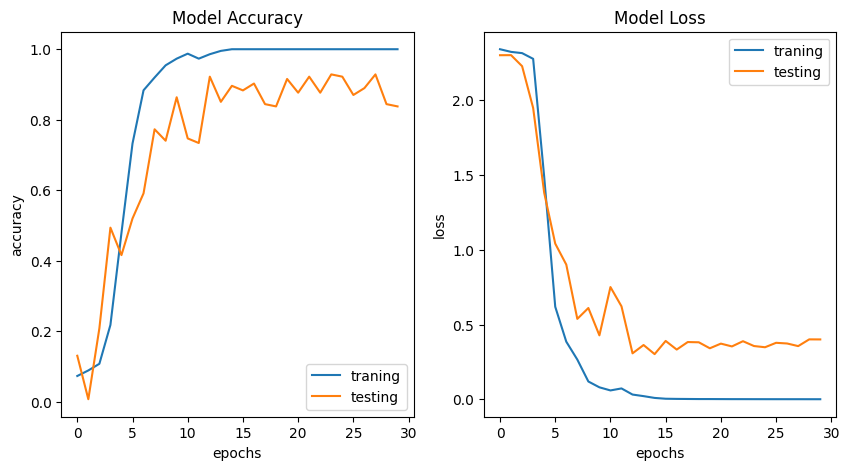

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

result = pd.DataFrame(CNN_history.history)

# Acc vs Epochs
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(result['accuracy'], label = 'traning')
plt.plot(result['val_accuracy'], label = 'testing')
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

# Loss vs Epochs
plt.subplot(1,2,2)
plt.plot(result['loss'], label = 'traning')
plt.plot(result['val_loss'], label = 'testing')
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# 載入訓練好的模型
model = CNN_model

# 自行定義標籤
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# 模型預測函數
def predict_image(img):
    # 將圖片轉換為模型期望的格式
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換為 RGB 格式
    img = cv2.resize(img, (ShapeOfImage, ShapeOfImage))  # 調整尺寸
    img = img.astype("float32") / 255.0  # 正規化
    img = np.expand_dims(img, axis=0)  # 擴展維度以符合模型輸入要求

    # 使用模型進行預測
    prediction = model.predict(img)

    # 取得預測結果的類別
    prediction_dict = {labels[index]: float(value) for index, value in enumerate(prediction[0])}


    return prediction_dict


# 設定圖像尺寸
ShapeOfImage = 100

# 創建 Gradio 介面
iface = gr.Interface(fn=predict_image,
                     inputs="image",
                     outputs="label")

# 啟動介面
iface.launch(debug=True)
iface.launch(share=True)